In [35]:
%matplotlib inline
import sys
import errno
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

Global variables that sets the type of coin evaluated, prediction distance, the range the volatility is calculated from, and the total number of the total 

In [36]:
# _coin_type = "bitcoin"
_volatility_range = 6
_change_flex = 0.5

Pulls the data from the appropriate url and saves it as a data frame

In [37]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=14400):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [38]:
all_data = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
all_data['ds'] = pd.to_datetime(all_data['date'], unit='s')

Prints frame data

In [39]:
all_data.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
count,622.000000,6.220000e+02,622.000000,622.000000,622.000000,622.000000,6.220000e+02,622.000000
mean,5851.423330,1.510488e+09,6065.363653,5580.149940,5843.578373,6712.643840,3.363674e+07,5823.461346
std,3970.632979,1.552610e+07,4167.594378,3718.552253,3974.906988,7149.110308,4.209415e+07,3938.180319
min,781.811601,1.483661e+09,823.498000,751.000000,781.851601,174.151784,3.275330e+05,787.033432
25%,2353.524262,1.497074e+09,2450.964375,2198.750000,2331.975000,1550.521067,7.248629e+06,2327.539087
50%,6230.000001,1.510488e+09,6369.552055,6019.462281,6220.851798,4739.368368,1.979696e+07,6238.198831
75%,8176.799642,1.523902e+09,8365.927250,7868.500000,8185.513621,8946.577068,4.230049e+07,8141.879760
max,19223.000000,1.537315e+09,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652


Selects the appropriate amount of data from the full frame

In [40]:
df = all_data[['ds','close']]
df.columns = ['ds','price']
df['log'] = np.log(df['price'])
df['vol'] = df['log'].rolling(_volatility_range).mean()

Pulls the dates and prices from the data and creates the log and volatility columns

Shows statistics for the three columns

In [41]:
df.describe()

,price,log,vol
count,622.000000,622.000000,617.000000
mean,5851.423330,8.378405,8.383238
std,3970.632979,0.845350,0.841112
min,781.811601,6.661614,6.700265
25%,2353.524262,7.763656,7.787670
50%,6230.000001,8.737130,8.749792
75%,8176.799642,9.009056,9.004251
max,19223.000000,9.863863,9.800502


Displays kurtosis for the three data sources

Kurtosis for log and vol is relatively low indicating that there aren't many extrema.

In [42]:
df.kurtosis()

price    0.254291
log     -0.953051
vol     -0.953337
dtype: float64

Displays skew for the three data sources

The skew is positive meaning that that the the graph is asymmetric with a left weight

In [43]:
df.skew()

price    0.735926
log     -0.511041
vol     -0.517137
dtype: float64

Defines a method to extract and forecast the specified data stream

In [44]:
m = Prophet(changepoint_prior_scale = _change_flex)
df['y'] = df['vol']
m.fit(df)

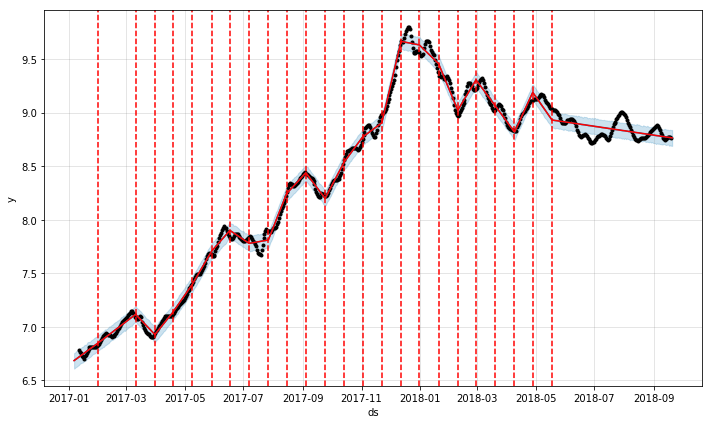

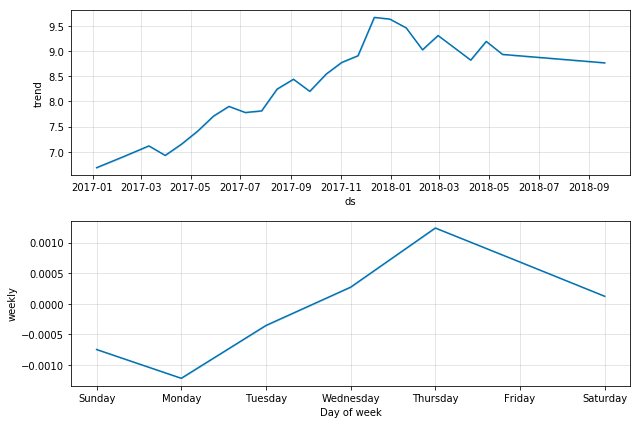

In [45]:
future = m.make_future_dataframe(periods=1)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

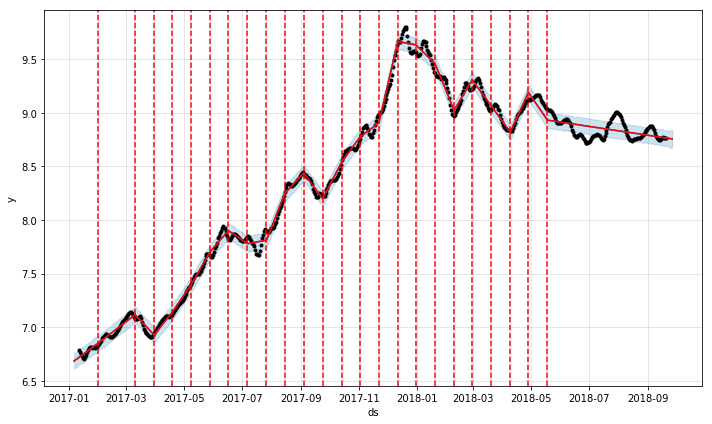

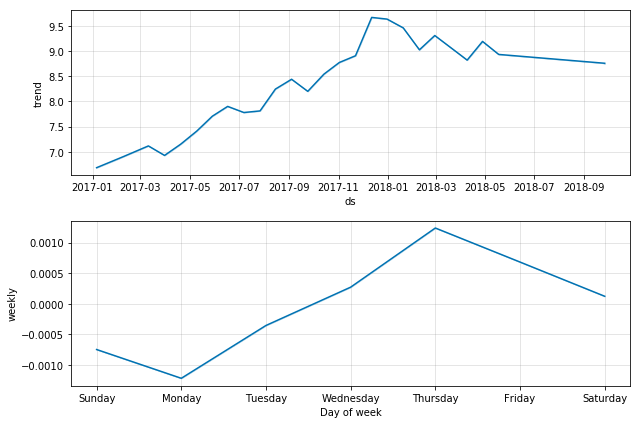

In [46]:
future = m.make_future_dataframe(periods=7)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

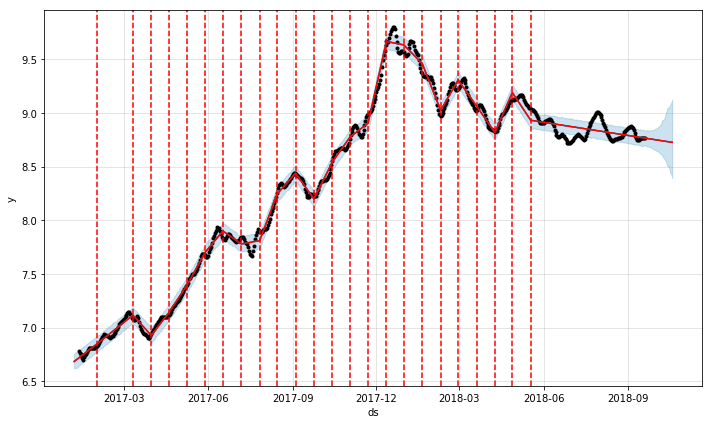

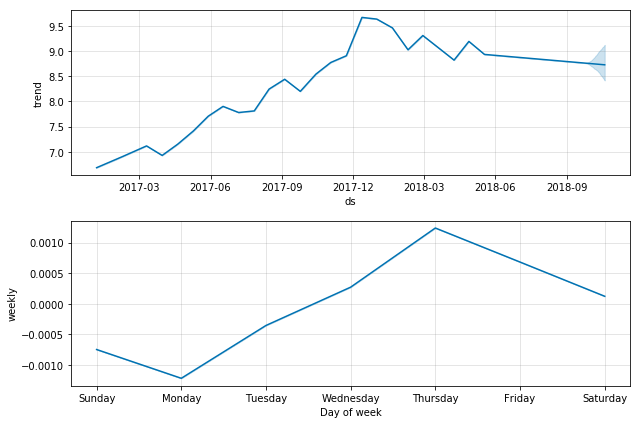

In [47]:
future = m.make_future_dataframe(periods=30)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

Defines method to plot the data with a red line and blue points overlayed

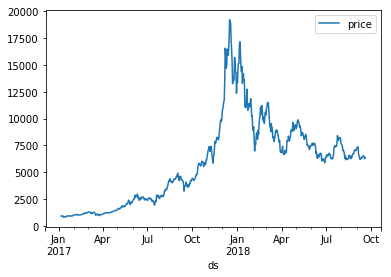

In [48]:
df.plot(x='ds', y ='price')

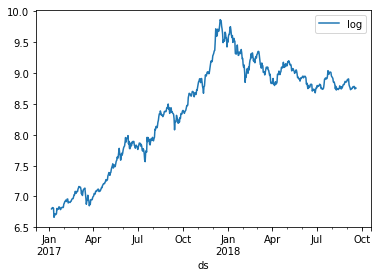

In [49]:
df.plot(x='ds', y ='log')

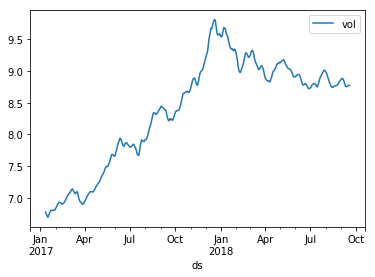

In [50]:
df.plot(x='ds', y ='vol')

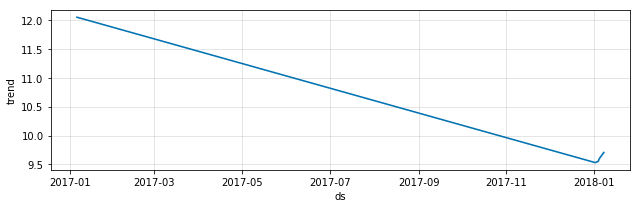

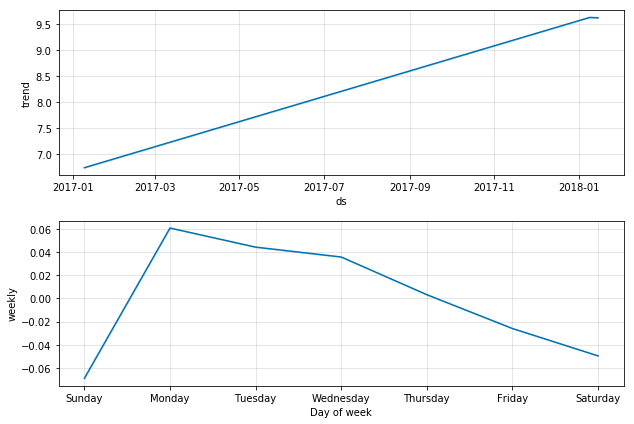

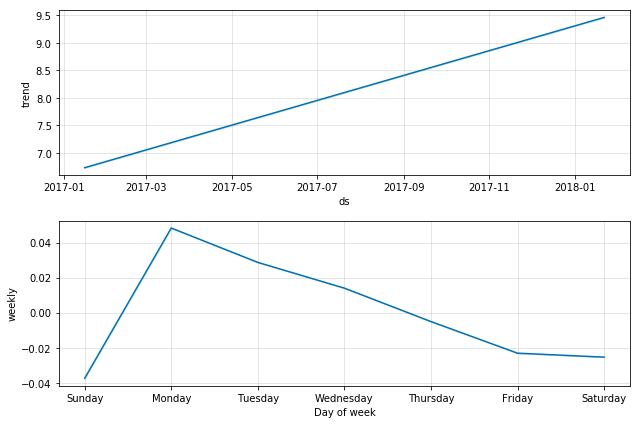

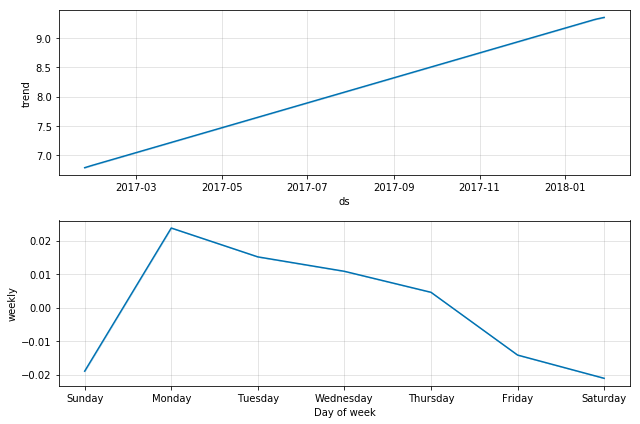

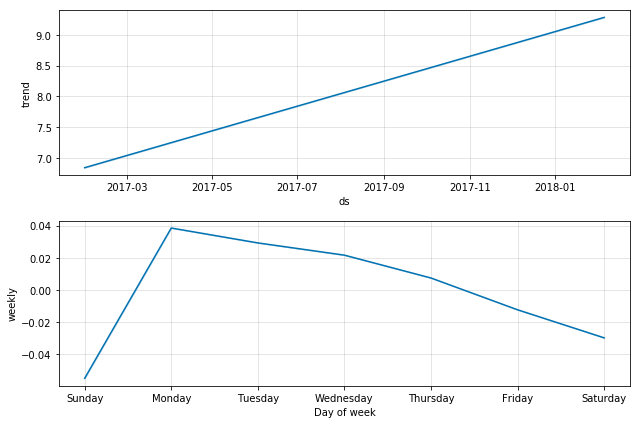

In [51]:
d = dict(tuple(df.groupby(df['ds'].dt.week)))
for i, df_week in d.items()[:5]:
    m = Prophet()
    m.fit(df_week)
    future = m.make_future_dataframe(periods=1)
    future.tail()
    forecast = m.predict(future)
    fig2 = m.plot_components(forecast)